## Simple example
This notebook shows how to train model

In [1]:
# Imports
import sys
import matplotlib.pyplot as plt
import cartopy
import torch

sys.path.append('../src/')
from DatasetUS import *
from TrainDiffusion import *
from TrainUnet import *



This example can be run on a laptop but won't train the network very well. We will train with just a small subset of data. 

In [2]:
## Select years to train and validate
train_year_start = 1953
train_year_end = 1955

valid_year_start = 1956
valid_year_end = 1957

Set up training hyperparameters. We will only run for 10 epochs and we will use the cpu. 

In [3]:
## Select hyperparameters of training
batch_size = 8
learning_rate = 1e-4
accum = 8

# Run training for small number of epochs 
num_epochs = 2        

# Define device
device =  'cuda' if torch.cuda.is_available() else 'cpu'

# define the ml model
unet_model = UNet((256, 128), 5, 3, label_dim=2, use_diffuse=False)
unet_model.to(device)

# define the datasets
datadir = "../data/"
dataset_train = UpscaleDataset(datadir, year_start=train_year_start, year_end=train_year_end,
                               constant_variables=["lsm", "z"])

dataset_test = UpscaleDataset(datadir, year_start=valid_year_start, year_end=valid_year_end,
                              constant_variables=["lsm", "z"])

dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)

Opening files
All files accessed. Creating tensors
torch.Size([3])
tensor([259.5524,  -6.4844,  -7.6029]) tensor([310.5276,   7.3752,   7.3651])
Opening constant variables file (e.g. land-sea mask, topography)
Normalize z
Mean:<xarray.DataArray 'z' ()>
array(4599.6445, dtype=float32), Std<xarray.DataArray 'z' ()>
array(6220.801, dtype=float32)
Dataset initialized.
Opening files
All files accessed. Creating tensors
torch.Size([3])
tensor([259.5524,  -6.4844,  -7.6029]) tensor([310.5276,   7.3752,   7.3651])
Opening constant variables file (e.g. land-sea mask, topography)
Normalize z
Mean:<xarray.DataArray 'z' ()>
array(4599.6445, dtype=float32), Std<xarray.DataArray 'z' ()>
array(6220.801, dtype=float32)
Dataset initialized.


In [4]:
print(len(dataloader_train), len(dataloader_test))

90 45


In [5]:
scaler = torch.cuda.amp.GradScaler()

# define the optimiser
optimiser = torch.optim.AdamW(unet_model.parameters(), lr=learning_rate)

# Define the tensorboard writer
writer = SummaryWriter("./runs_unet")

loss_fn = torch.nn.MSELoss()

# train the model
losses = []

Start the training loop. The plots generated will show the coarse res, the predicted, and the truth for a few samples and for different variables. At the start of training the first two columns (coarse res and predicted) look similar. Towards the end of the training, the last two columns (predicted and truth) should look similar. 

Train :: Epoch: 0: 100%|██████| 90/90 [00:27<00:00,  3.33it/s, Loss: 0.9795]


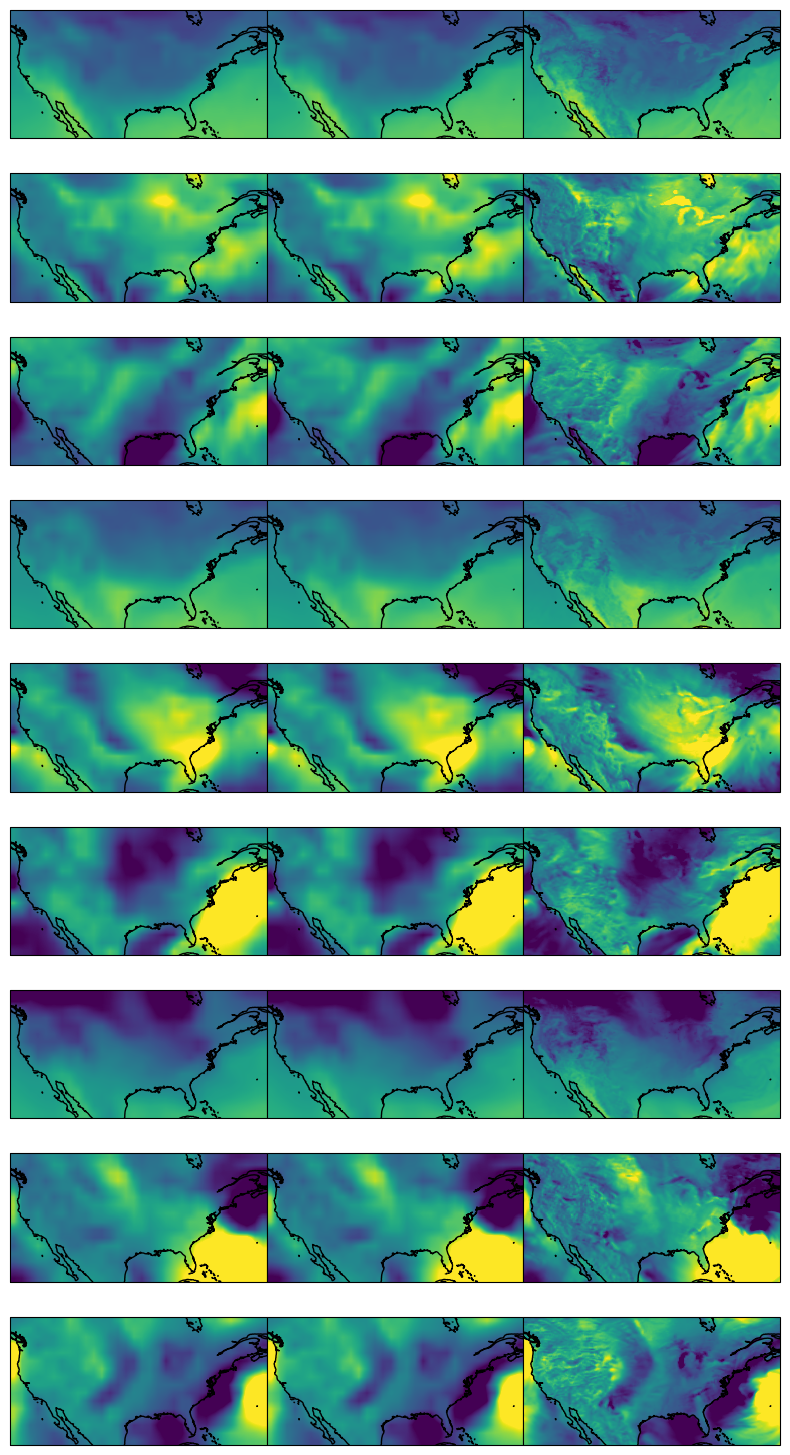

Train :: Epoch: 1: 100%|██████| 90/90 [00:27<00:00,  3.30it/s, Loss: 0.8767]


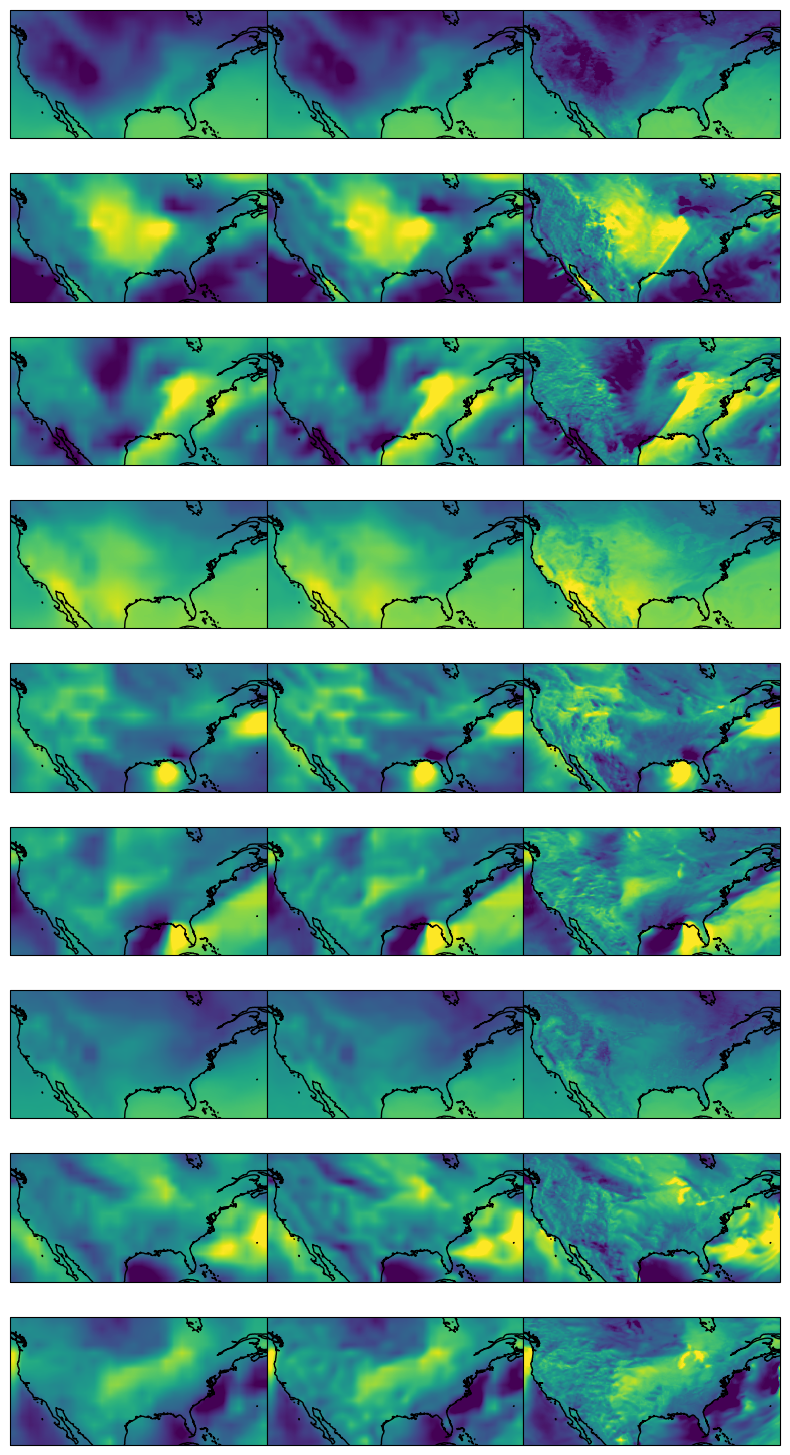

In [6]:
for step in range(num_epochs):
    epoch_loss = train_step(
        unet_model, loss_fn, dataloader_train, optimiser,
        scaler, step, accum, writer, device=device)
    losses.append(epoch_loss)

    (fig, ax), (base_error, pred_error) = sample_model(
        unet_model, dataloader_test, device=device)
    plt.show()

    writer.add_scalar("Error/base", base_error, step)
    writer.add_scalar("Error/pred", pred_error, step)
